# Ethereum Price Regression model
The aim of this notebook is to build a model that can predict the price of the cryptocurreny Ethereum, given past data (4 years of daily price data).
> How well can we predict the closing price of one Ether, given its previous closing price data?

Note that this nb is not treating the data sequentially.

<hr/>

Data can be source from Yahoo at this link: https://au.finance.yahoo.com/quote/ETH-AUD/history?period1=1541376000&period2=1604534400&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true, between the periods of 18/11/2016 to 05/11/2020.

### Setup up env and look at data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Import preprocessed data (if it exists)
df = pd.read_csv("data/processed_ETH-AUD",
                    low_memory=False)

In [3]:
price_data = pd.read_csv("./data/ETH-AUD-2016to2020.csv",
                         low_memory=False)

price_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-11-18,13.501419,13.527241,12.809084,12.901511,12.901511,14725799
1,2016-11-19,12.910578,13.268645,12.909572,13.155561,13.155561,7061320
2,2016-11-20,13.153451,13.221361,13.009252,13.079301,13.079301,7063653
3,2016-11-21,13.080503,13.157393,12.946662,13.046948,13.046948,4967737
4,2016-11-22,13.053648,13.856814,12.990789,13.371652,13.371652,15232721


In [4]:
price_data.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [5]:
print(price_data.shape)
print()
print(price_data.dtypes)
print()
print(price_data.info());

(1462, 7)

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1462 non-null   object 
 1   Open       1462 non-null   float64
 2   High       1462 non-null   float64
 3   Low        1462 non-null   float64
 4   Close      1462 non-null   float64
 5   Adj Close  1462 non-null   float64
 6   Volume     1462 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 80.1+ KB
None


In [6]:
# Function for precprocessing the data
def preprocess_data(df):
    """
    Performs transformations on df and returns transformed df.
    """
    
    # Drop Adj Close (duplicate data)
    price_data.drop(["Adj Close"], axis=1, inplace=True)
    
    # Transform Date into pd.readable form
    price_data["Date"] = pd.to_datetime(price_data["Date"])
    df["saleYear"] = df.Date.dt.year
    df["saleMonth"] = df.Date.dt.month
    df["saleDay"] = df.Date.dt.day
    df["saleDayOfWeek"] = df.Date.dt.dayofweek
    df["saleDayOfYear"] = df.Date.dt.dayofyear
    # Drop Date
    df.drop(["Date"], axis=1, inplace=True)
    
    # Scale Volume data between 0 and 1000
    min_max_scaler = MinMaxScaler(feature_range=(0, 1000))
    price_data["Volume"] = min_max_scaler.fit_transform(pd.DataFrame(price_data["Volume"]))

    return df

In [7]:
df = preprocess_data(price_data)
df

,Open,High,Low,Close,Volume,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear
0,13.501419,13.527241,12.809084,12.901511,0.222003,2016,11,18,4,323
1,12.910578,13.268645,12.909572,13.155561,0.051970,2016,11,19,5,324
2,13.153451,13.221361,13.009252,13.079301,0.052022,2016,11,20,6,325
3,13.080503,13.157393,12.946662,13.046948,0.005525,2016,11,21,0,326
4,13.053648,13.856814,12.990789,13.371652,0.233249,2016,11,22,1,327
...,...,...,...,...,...,...,...,...,...,...
1457,652.833923,653.569824,623.068298,632.921814,314.558834,2020,11,14,5,319
1458,632.921936,634.083069,605.527161,613.828186,313.547229,2020,11,15,6,320
1459,613.828064,633.913269,611.277710,628.373657,346.664635,2020,11,16,0,321
1460,634.475647,660.155151,629.372925,658.429077,443.646459,2020,11,17,1,322


In [8]:
# Save/Export processed dataframe
df.to_csv("data/processed_ETH-AUD",
              index=False)

In [9]:
# df_train = df[ df.saleYear == 2020 ]
# df_test = df[ df.saleYear != 2020]

# # Split data into X & y, and split
# X_train, y_train = df_train.drop("Close", axis=1), df_train.Close
# X_test, y_test = df_test.drop("Close", axis=1), df_test.Close

X = df.drop(["Close"], axis=1)
y = df["Close"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False, stratify=None)

In [11]:
%%time

# Change max samples in RandomForestRegressor
model = RandomForestRegressor(n_jobs=-1)

model.fit(X_train, y_train)

y_preds = model.predict(X_test)
y_preds[:5]
X_test[:5]

CPU times: user 581 ms, sys: 43.1 ms, total: 625 ms
Wall time: 295 ms


,Open,High,Low,Volume,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear
1169,275.379547,276.973145,263.365417,388.593154,2020,1,31,4,31
1170,269.067474,274.642273,268.516846,383.326416,2020,2,1,5,32
1171,274.174622,288.500549,269.215729,465.773763,2020,2,2,6,33
1172,281.817017,289.108826,281.001892,410.803919,2020,2,3,0,34
1173,283.765442,283.916748,275.437103,385.966725,2020,2,4,1,35


In [12]:
show_scores(model)

{'Test Accuracy': 0.9937848935964947,
 'Training MAE': 3.312364469871664,
 'Test MAE': 6.518191567781581,
 'Training RMSLE': 0.012573204381519409,
 'Test RMSEL': 0.025900760206557273,
 'Training R^2': 0.9995229377031819,
 'Test R^2': 0.9937848935964947}

In [13]:
model.score(X_test, y_test)
# NOTE: This score is too high

0.9937848935964947

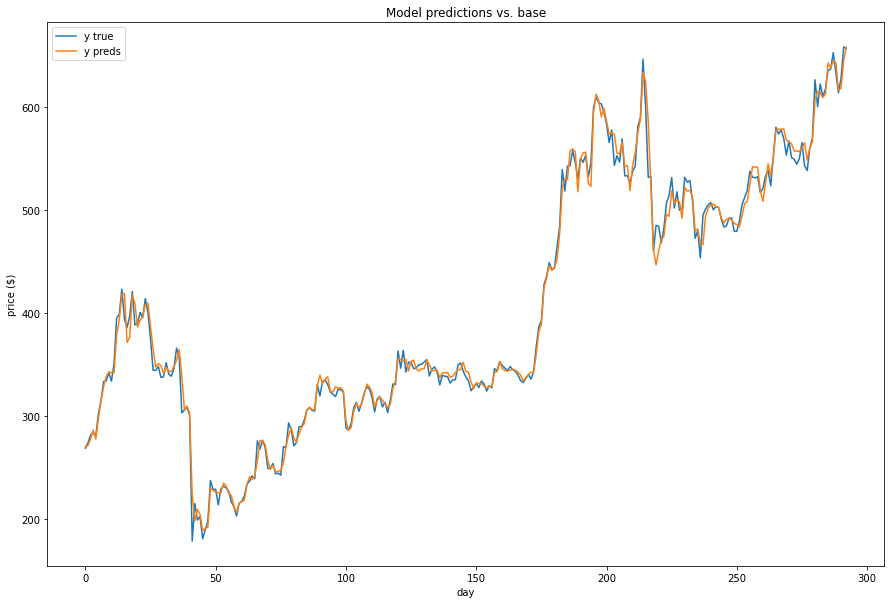

In [14]:
fig, ax = plt.subplots(figsize=(15,10)) # (width, height)
ax.plot(range(0,293), y_test)
ax.plot(range(0,293), y_preds)
ax.set(title="Model predictions vs. base", 
       xlabel="day",
       ylabel="price ($)")
ax.legend(['y true', 'y preds'])

plt.show()

In [15]:
y_preds.shape, y_test.shape

((293,), (293,))

In [16]:
print(y_test.std())
print(y_preds.std())
print()

y_preds_df = pd.DataFrame(y_preds, y_test)
print(y_preds_df)

122.05198338916829
121.50021954725287

                     0
Close                 
269.136780  270.694705
274.385925  271.647234
281.832123  278.054499
283.770416  286.764012
281.152222  278.129965
...                ...
632.921814  643.567062
613.828186  616.011987
628.373657  618.554002
658.429077  644.809240
656.795837  658.003168

[293 rows x 1 columns]


In [17]:
# Helper function for plotting feature importance
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                        "feature_importances": importances})
          .sort_values("feature_importances", ascending=False)
          .reset_index(drop=True))
    
    # Plot the dataframe
    fig, ax = plt.subplots(figsize=(15, 12))
    ax.barh(df["features"][:n], df["feature_importances"][:20])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature importance")
    ax.invert_yaxis()

## RandomizedSearchCV

In [18]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# Different RandomForestRegressor hyperparameters
rf_grid = {"n_estimators": np.arange(10, 100, 10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_features": [0.5, 1, "sqrt", "auto"]}

# Instantiate RandomizedSearchCV model
# NOTE: if we had the time we would boost n_iter to try out far more combinations
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                   random_state=42),
                              param_distributions=rf_grid,
                              n_iter=50,
                              cv=5,
                              verbose=True)

# Fit the RandomizedSearchCV model
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CPU times: user 13.4 s, sys: 1.41 s, total: 14.9 s
Wall time: 24.9 s


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:   24.8s finished


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=50,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [19]:
# Find the best model hyperparameters
rs_model.best_params_

{'n_estimators': 60,
 'min_samples_split': 4,
 'min_samples_leaf': 7,
 'max_features': 'auto',
 'max_depth': 10}

In [20]:
# Evaluate the RandomizedSearch model
show_scores(rs_model)

{'Test Accuracy': 0.9939019524312154,
 'Training MAE': 6.759372754893651,
 'Test MAE': 6.572452114145861,
 'Training RMSLE': 0.029463797227911592,
 'Test RMSEL': 0.025459436900264976,
 'Training R^2': 0.9974775007224029,
 'Test R^2': 0.9939019524312154}

In [21]:
%%time 

# Train model with the best params
ideal_model = RandomForestRegressor(n_estimators=40,
                                    min_samples_leaf=4,
                                    min_samples_split=5,
                                    max_features='auto',
                                    max_depth=None,
                                    n_jobs=1,
                                    random_state=42)

ideal_model.fit(X_train, y_train)

CPU times: user 137 ms, sys: 4.29 ms, total: 141 ms
Wall time: 159 ms


RandomForestRegressor(min_samples_leaf=4, min_samples_split=5, n_estimators=40,
                      n_jobs=1, random_state=42)

## Results analysis

In [64]:
# Create evaluation function (the competition uses RMSLE)
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score, mean_squared_error, explained_variance_score,max_error

# NOTE: root_mean_squared_log_error is added by me to scikit-learn, ordinarily we would need
# to use this function:
def rmsle(y_test, y_preds):
    """
    Calculates root mean squared log error between predictions and
    true labels.
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create function to evaluate model on a few different levels
def show_scores(model):
    train_preds = model.predict(X_train)
    y_pred = model.predict(X_test)
    scores = {"Test MAE": mean_absolute_error(y_test, y_pred),
             "Test MSE": mean_squared_error(y_test, y_pred),
             "Test RMSLE": rmsle(y_test, y_pred),
             "Test R^2": r2_score(y_test, y_pred),
             "Explained Variance": explained_variance_score(y_test, y_pred)}
    
    return scores

In [65]:
show_scores(ideal_model)

{'Test MAE': 6.584068251058241,
 'Test MSE': 88.17358721657524,
 'Test RMSLE': 0.024904637571026726,
 'Test R^2': 0.9940607227875783,
 'Explained Variance': 0.9940612384020988}

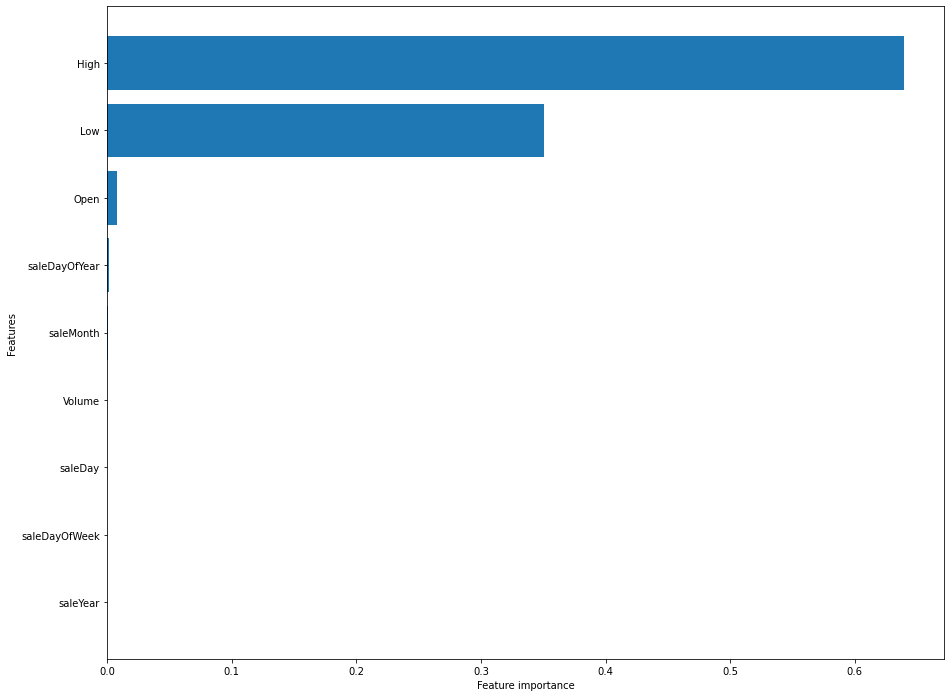

In [26]:
plot_features(X_train.columns, ideal_model.feature_importances_)

Text(0, 0.5, 'price difference')

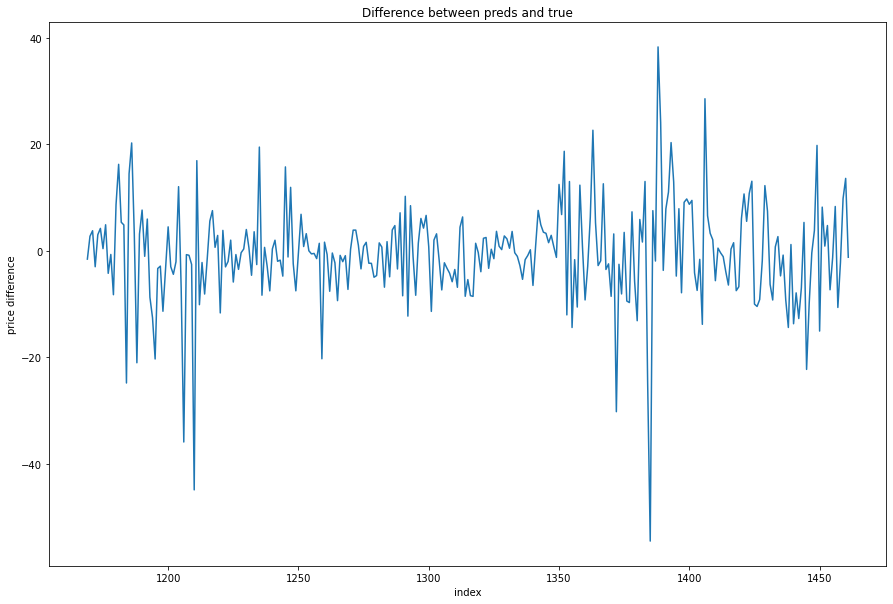

In [54]:
difference = y_test-y_preds
figt = difference.plot(figsize=(15,10));

plt.title("Difference between preds and true");
plt.xlabel("index")
plt.ylabel("price difference")

In [66]:
# Data exploration
HigherThanOpen = X_train.apply(lambda row, index: True if row["Open"] < y_train[index] else False, 
                                           axis=1)

def PredHigherThanTrue(y_preds, y_true):
    array = []
    for i in range(len(y_preds)):
        array.append(True) if y_preds[i] > y_true[i] else array.append(False)
             


print(HigherThanOpen.value_counts())

TypeError: <lambda>() missing 1 required positional argument: 'index'

## Results

The model seems to predict close price pretty well based on the basic parameters given, with a Mean Average error of around $6.

Whats interesting is that the model has put the parameter (daily price) High as the most importance feature. 

However in its current form, it is not very useful as it requires full day statistics to atcually dervice the price prediction. This could be changed by adding some kidn of future prediction as y_true. The model could also be improved throgh feature engineering of common indicators. 